# Accuracy Assessment of WOfS Product in Africa using Ground Truth Data  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_summary),
[usgs_ls8c_level2_2]()

Notes:
* Landsat 8 collection 2 is confidential at continental level on 26 June 2020.
* This notebook should be run in Collection 2 Read Private Workspace should we need to run the Landsat 8 Collection 2 Sample dataset. 

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat 8 Collection 2 surface reflectance and shows surface water detected in Africa.
Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

The data in a WOFL is stored as a bit field. This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc). In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 
For more information on the structure of WOFLs and how to interact with them, see [Water Observations from Space](../Datasets/Water_Observations_from_Space.ipynb) and [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebooks. 

Accuracy assessment for WOfS product in Africa includes generating a confusion error matrix for a WOFL binary classification.
The inputs for the estimating the accuracy of WOfS derived product are a binary classification WOFL layer showing water/non-water and a shapefile containing validation points collected by [Collect Earth Online](https://collect.earth/) tool. Validation points are the ground truth or actual data while the extracted value for each location from WOFL is the predicted value. A confusion error matrix containing overall, producer's and user's accuracy is the output of this analysis. 

## Description
This notebook explains how you can perform accuracy assessment for WOFS derived product using collected ground truth dataset. 

The notebook demonstrates how to:

1. Load validation points for each partner institutions as a list of observations each has a location and month
2. Query WOFL data for validation points and capture available WOfS observation available
3. Extract statistics for each WOfS observation in each validation point including min, max and mean values for each point (location and month)
4. Extract a LUT for each point that contains both validation info and WOfS result for each month 
5. Generating a confusion error matrix for WOFL classification
6. Assessing the accuracy of the classification 
***

* Two extreme cases: 
    - only test wofs classifier and excluding clouds is ok 
     - keep clear observations and remove non-clear ones
     - then query on those that are water/non-water
    - include terrain so water observed and no terrain is predicted true 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages
Import Python packages that are used for the analysis.

In [8]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import plot_confusion_matrix, f1_score  
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

### Loading Dataset

In [9]:
#Read in the validation data csv, clean the table and rename the column associated with actual and predicted 
#you need to read two columns from this table:
# a. Water flag as the groundtruth(actual)
# b. Class Wet from WOfS as prediction 
CEO = '../Supplementary_data/Validation/Refined/ground_truth_RCMRD_final.csv'
df = pd.read_csv(CEO,delimiter=",")
input_data = df.drop(['Unnamed: 0','Unnamed: 0.1', 'FLAGGED', 'ANALYSES','SENTINEL2Y', 'WATER', 'NO_WATER', 'BAD_IMAGE', 'NOT_SURE','COMMENT','geometry'], axis=1)
input_data = input_data.rename(columns={'WATERFLAG':'ACTUAL'})

In [10]:
#setting the column prediction based on frequency flag or using class_wet flag 
#input_data['PREDICTION'] = input_data['FREQUENCY'].apply(lambda x: '1' if x > 0.5 else '0')
input_data['PREDICTION'] = input_data['CLASS_WET'].apply(lambda x: '1' if x >=1 else '0') #you need to comment after this 

In [11]:
input_data 

,PLOT_ID,LON,LAT,CLASS,MONTH,ACTUAL,CLASS_WET,CLASS_DRY,CLEAR_OBS,FREQUENCY,PREDICTION
0,137387037.0,29.875854,2.178788,Open water - freshwater,1,1,1.0,0.0,1.0,1.0,1
1,137387037.0,29.875854,2.178788,Open water - freshwater,2,1,1.0,0.0,1.0,1.0,1
2,137387037.0,29.875854,2.178788,Open water - freshwater,3,1,1.0,0.0,1.0,1.0,1
3,137387037.0,29.875854,2.178788,Open water - freshwater,5,1,2.0,0.0,2.0,1.0,1
4,137387037.0,29.875854,2.178788,Open water - freshwater,6,1,1.0,0.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
6141,137387436.0,34.410695,-9.881259,Open water - freshwater,5,1,1.0,0.0,1.0,1.0,1
6142,137387436.0,34.410695,-9.881259,Open water - freshwater,6,1,2.0,0.0,2.0,1.0,1
6143,137387436.0,34.410695,-9.881259,Open water - freshwater,7,1,2.0,0.0,2.0,1.0,1
6144,137387436.0,34.410695,-9.881259,Open water - freshwater,9,1,1.0,0.0,1.0,1.0,1


In [12]:
#calculating the number of mixed classes 
a = input_data[input_data['ACTUAL']==1]['PLOT_ID'].unique()
b = input_data[input_data['ACTUAL']==0]['PLOT_ID'].unique()
c = np.intersect1d(a,b)
len(c)

99

In [6]:
#excluding the points that are not ephemeral (in group c) and save it as permenant 
permanent=input_data[~input_data['PLOT_ID'].isin(c)]
#len(permanent)

In [7]:
confusion_matrix = pd.crosstab(permanent['ACTUAL'],permanent['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
confusion_matrix 

PREDICTION,0,1,All
ACTUAL,,,
0,800,31,831
1,518,3900,4418
All,1318,3931,5249


In [7]:
input_data[input_data['PLOT_ID'].isin(c)]['CLASS'].value_counts()

Open water - freshwater                        447
Wetlands - freshwater                          206
Open water - marine                            128
Wetlands - marine (e.g. mangroves)              59
Barren (Bare soil / Rocky Land)                 34
Open water - Constructed (e.g. aquaculture)     12
Herbaceous/Grassland                            11
Name: CLASS, dtype: int64

In [8]:
input_data[(input_data['ACTUAL']==1) & (input_data['PREDICTION']=='0')]['CLASS'].value_counts()

Open water - freshwater                        398
Open water - marine                             91
Wetlands - freshwater                           69
Wetlands - marine (e.g. mangroves)              20
Shrubs                                           8
I am unsure                                      5
Open water - Constructed (e.g. aquaculture)      3
Herbaceous/Grassland                             1
Name: CLASS, dtype: int64

In [12]:
check = input_data[(input_data['ACTUAL']==1) & (input_data['PREDICTION']=='0')][['PLOT_ID','LAT','LON','CLASS','MONTH','ACTUAL','PREDICTION']]

In [13]:
check 

,PLOT_ID,LAT,LON,CLASS,MONTH,ACTUAL,PREDICTION
5,137387037.0,2.178788,29.875854,Open water - freshwater,7,1,0
14,137387038.0,0.893874,27.272168,Open water - freshwater,12,1,0
70,137387047.0,-10.597377,32.112338,Open water - freshwater,10,1,0
77,137387049.0,-11.006082,39.513597,Open water - freshwater,11,1,0
121,137387057.0,-12.922583,40.403154,Open water - freshwater,7,1,0
...,...,...,...,...,...,...,...
6106,137387430.0,-9.073325,37.568139,I am unsure,5,1,0
6107,137387430.0,-9.073325,37.568139,I am unsure,6,1,0
6108,137387430.0,-9.073325,37.568139,I am unsure,7,1,0
6109,137387430.0,-9.073325,37.568139,I am unsure,8,1,0


In [14]:
#save the check list into a csv file 
check.to_csv(('../Supplementary_data/Validation/Refined/RCMRD_check.csv'))

### Calculate confusion matrix 

To do the accuracy assesssment of the validation in each AEZ , we need to obtain WOfS surface water observation data that corresponds with the labelled input data locations. 

In [164]:
confusion_matrix = pd.crosstab(input_data['ACTUAL'],input_data['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],margins=True)
confusion_matrix 

PREDICTION,0,1,All
ACTUAL,,,
0,1047,134,1181
1,595,4370,4965
All,1642,4504,6146


### Calculating User Accuracy (Commission)

Computed by dividing the number of correctly classified pixel in each category by the total number of pixels that were classified in that category(the row total). This value represents 
the probability that a pixel classified into a given category actually represents that category on the ground. 

In [165]:
confusion_matrix["User's"] = [confusion_matrix.loc[0][0] / confusion_matrix.loc[0]['All'] * 100, confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All'] *100, np.nan]
confusion_matrix

PREDICTION,0,1,All,User's
ACTUAL,,,,
0,1047,134,1181,88.653683
1,595,4370,4965,88.016113
All,1642,4504,6146,NaN


### Calculating Producer's Accuracy (Omission)

Deviding the number of correctly classified pixels in each category (on the major diagonal) by the numbr of reference pixels "known" to be of that category (the column total)
This value represents how well reference pixels of the ground cover type are classified.

In [167]:
producers_accuracy = pd.Series([confusion_matrix['0'][0] / confusion_matrix['0']['All'] * 100,
                                confusion_matrix['1'][1] / confusion_matrix['1']['All'] * 100]).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)
confusion_matrix 

,0,1,All,User's,0,1
ACTUAL,,,,,,
0,1047.0,134.0,1181.0,88.653683,NaN,NaN
1,595.0,4370.0,4965.0,88.016113,NaN,NaN
All,1642.0,4504.0,6146.0,NaN,NaN,NaN
Producer's,NaN,NaN,NaN,NaN,63.763703,97.024867


### Calculating Overall Accuracy 

In [169]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix.loc[0, 0] + 
                                                confusion_matrix.loc[1, 1]) / confusion_matrix.loc['All', 'All'] * 100
confusion_matrix

,0,1,All,User's,0,1
ACTUAL,,,,,,
0,1047.0,134.0,1181.0,88.653683,NaN,NaN
1,595.0,4370.0,4965.0,88.016113,NaN,NaN
All,1642.0,4504.0,6146.0,NaN,NaN,NaN
Producer's,NaN,NaN,NaN,NaN,63.763703,97.024867


In [170]:
fscore = pd.Series([(2*(confusion_matrix.loc[0, "User's"]*confusion_matrix.loc["Producer's", 0]) / (confusion_matrix.loc[0, "User's"] + confusion_matrix.loc["Producer's", 0])) / 100,
                    f1_score(input_data['ACTUAL'], input_data['PREDICTION'])]).rename("F-score")

confusion_matrix = confusion_matrix.append(fscore)

TypeError: '<' not supported between instances of 'str' and 'int'

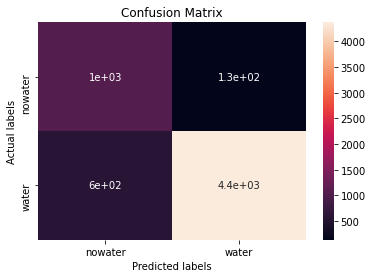

In [9]:
confusion_matrix = pd.crosstab(input_data['ACTUAL'],input_data['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'])
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True) #true to annotate cells 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['nowater','water']); ax.yaxis.set_ticklabels(['nowater','water']);
plt.show()

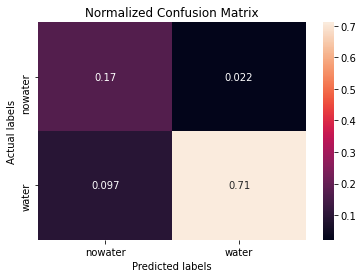

In [10]:
confusion_matrix = pd.crosstab(input_data['ACTUAL'],input_data['PREDICTION'],rownames=['ACTUAL'],colnames=['PREDICTION'],normalize=True)
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True) #true to annotate cells 
ax.set_xlabel('Predicted labels'); ax.set_ylabel('Actual labels');
ax.set_title('Normalized Confusion Matrix')
ax.xaxis.set_ticklabels(['nowater','water']); ax.yaxis.set_ticklabels(['nowater','water']);

In order to evaluate the accuracy of the classification

The function `collect_training_data` takes our shapefile containing class labels and extracts training data from the datacube over the location specified by the input geometries. The function will also pre-process our training data by stacking the arrays into a useful format and removing an `NaN` (not-a-number) values.


> **The following cell can take several minutes to run.** The class labels will be contained in the first column of the output array.  If you set `ncpus > 1`, then this function will be run in parallel across the specified number of processes.

In [2]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)

In [ ]:
#test the groundtruth with a 6933 EPSG as well (conversion) - how to reproject